In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2020-11-07 15:45:11--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  22.0MB/s    in 17s     

2020-11-07 15:45:28 (18.7 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
 import tensorflow as tf

In [3]:
import zipfile,os
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()
 
base_dir = 'rockpaperscissors'
os.listdir('rockpaperscissors')

['rock', 'scissors', 'README_rpc-cv-images.txt', 'paper', 'rps-cv-images']

In [4]:
rps_isi = 'rockpaperscissors/rps-cv-images'
os.listdir('rockpaperscissors/rps-cv-images')

['rock', 'scissors', 'README_rpc-cv-images.txt', 'paper']

In [5]:
!rm -rf 'rockpaperscissors/rps-cv-images/README_rpc-cv-images.txt'

In [6]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(rps_isi):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [7]:
import pandas as pd
 
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
paper       712
rock        726
scissors    750
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
 
X= df['path']
y= df['tag']

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.399, random_state=0)
 
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})
 
df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [10]:
print('train size', len(df_tr))
print('val size', len(df_val))

train size 1314
val size 874


In [11]:
df_all = df_tr.append([df_val]).reset_index(drop=1)\
 
print(df_all.groupby(['set','tag']).size(),'\n')

set         tag     
train       paper       427
            rock        428
            scissors    459
validation  paper       285
            rock        298
            scissors    291
dtype: int64 



In [12]:
import shutil
from tqdm.notebook import tqdm as tq
 
datasource_path = 'rockpaperscissors/rps-cv-images/'
dataset_path = "dataset/"

In [13]:
for index, row in tq(df_all.iterrows()):
    
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path.split('.')[0])            
    
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [14]:
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

In [15]:
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [16]:
train_generator = train_datagen.flow_from_directory('dataset/train/', target_size=(150, 150), batch_size=16, class_mode='categorical', shuffle=True)
val_generator = val_datagen.flow_from_directory('dataset/validation/', target_size=(150, 150), batch_size=16, class_mode='categorical', shuffle=True)
num_class = train_generator.num_classes

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [17]:
model = tf.keras.models.Sequential([    
                                     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),    
                                     tf.keras.layers.MaxPooling2D(2, 2),    
                                     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),    
                                     tf.keras.layers.MaxPooling2D(2,2),    
                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),    
                                     tf.keras.layers.MaxPooling2D(2,2),    
                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),    
                                     tf.keras.layers.MaxPooling2D(2,2),    
                                     tf.keras.layers.Flatten(),    
                                     tf.keras.layers.Dense(512, activation='relu'),    
                                     tf.keras.layers.Dense(3, activation='softmax')])

In [18]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator
train_data = tf_data_generator(train_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [19]:
 model.compile(loss='categorical_crossentropy',
               optimizer=tf.optimizers.Adam(),
               metrics=['accuracy'])

In [20]:
EPOCH = 20
history = model.fit(x=train_data,
        steps_per_epoch=25,
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=5,
        verbose = 2)

Epoch 1/20
25/25 - 20s - loss: 1.1007 - accuracy: 0.3625 - val_loss: 1.1181 - val_accuracy: 0.2750
Epoch 2/20
25/25 - 20s - loss: 1.0111 - accuracy: 0.4750 - val_loss: 0.6536 - val_accuracy: 0.8000
Epoch 3/20
25/25 - 20s - loss: 0.5452 - accuracy: 0.8150 - val_loss: 0.4744 - val_accuracy: 0.8750
Epoch 4/20
25/25 - 19s - loss: 0.3870 - accuracy: 0.8549 - val_loss: 0.3971 - val_accuracy: 0.8875
Epoch 5/20
25/25 - 20s - loss: 0.3172 - accuracy: 0.8825 - val_loss: 0.3652 - val_accuracy: 0.8500
Epoch 6/20
25/25 - 20s - loss: 0.2872 - accuracy: 0.8825 - val_loss: 0.3231 - val_accuracy: 0.9000
Epoch 7/20
25/25 - 19s - loss: 0.3096 - accuracy: 0.8912 - val_loss: 0.2078 - val_accuracy: 0.9125
Epoch 8/20
25/25 - 20s - loss: 0.2179 - accuracy: 0.9100 - val_loss: 0.1916 - val_accuracy: 0.9375
Epoch 9/20
25/25 - 20s - loss: 0.1815 - accuracy: 0.9525 - val_loss: 0.1686 - val_accuracy: 0.9500
Epoch 10/20
25/25 - 19s - loss: 0.1101 - accuracy: 0.9637 - val_loss: 0.4035 - val_accuracy: 0.8875
Epoch 11/

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Saving 0OEXfEooCXlljaEl.png to 0OEXfEooCXlljaEl.png
0OEXfEooCXlljaEl.png
rock


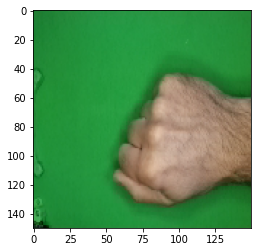

In [22]:
uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
 
  print(fn)
  if classes[0,0]==1:
    print('paper')
  elif classes[0,1]==1:
    print('rock')
  elif classes[0,2]==1:
    print('scissors')
  else:
    print('tidak terdeteksi')


*   Nama : Fitria Salma
*   Email : fitriasalmafourth@gmail.com
*   Asal : Klaten
*   Tanggal lahir : 10 12 199



